In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import json
# Import the Class class.
from classy import Class
# Import velocileptors.
from velocileptors.LPT.lpt_rsd_fftw import LPT_RSD
# Import error function and a spline.
from scipy.special     import erfc
from scipy.interpolate import InterpolatedUnivariateSpline as Spline

## LBG clustering

Let's look at the clustering of LBGs in the mocks, using pre-generated data files created by AbacusHOD and theoretical predictions from Velocileptors, and compare that to some (angular) clustering data.

In [3]:
lbg = json.load(open("lbg_clustering_c000_ph000_r.json","r"))
Lbox= lbg['BoxSize']
mpar= lbg['ParticleMassHMsun']
# Let's just print some into information here.  We will fill
# in the full table a bit more later.
print("# OmM={:.3f}, H0={:.2f}, z={:.2f}".format(lbg['Omega_M'],lbg['H0'],lbg['Redshift']))
print("# Simulation box of side length {:.0f}Mpc/h.".format(Lbox))
print("# Particle mass is {:.2e}Msun/h".format(mpar))
print("# {:33s} {:>6s} {:>10s}".format('HOD params','fsat','nbar'))
for samp in lbg['mocks'][:5]:
    hodstr = ""
    for p in samp['hod']: hodstr += " {:6.2f}".format(p)
    print(hodstr+" {:6.2f} {:10.2e}".format(samp['fsat'],samp['nobj']/Lbox**3))
print("  etc.")

# OmM=0.315, H0=67.36, z=3.00
# Simulation box of side length 2000Mpc/h.
# Particle mass is 2.11e+09Msun/h
# HOD params                          fsat       nbar
  12.00  13.40   0.30   1.00   0.75   0.04   1.18e-03
  12.00  13.40   0.40   1.00   0.75   0.02   1.68e-03
  12.05  13.45   0.30   1.00   0.75   0.03   9.84e-04
  12.05  13.45   0.40   1.00   0.75   0.02   1.42e-03
  12.10  13.50   0.30   1.00   0.75   0.03   8.18e-04
  etc.


### Linear theory

First set up the linear theory and background quantities for this cosmology using CLASS.

In [4]:
# Set up the class instance.
params = {
    'output': 'tCl lCl mPk',
    'l_max_scalars': 2000,
    'P_k_max_h/Mpc': 50.,
    'z_pk': '0.0,10',
    'lensing': 'yes',
    'A_s': np.exp(3.040)*1e-10,
    'n_s': 0.96824,
    'h': 0.6770,
    'N_ur': 2.0328,
    'N_ncdm': 1,
    'tau_reio': 0.0568,
    'omega_b': 0.022447,
    'omega_cdm': 0.11923}
# Now update some keys with N-body values.
for k in ['n_s','omega_b','omega_cdm',\
          'omega_ncdm','N_ncdm','N_ur']:
    print("Setting ",k," = ",lbg[k])
    params[k] = lbg[k]
params['h'] = lbg['H0']/100.0
#
cosmo = Class()
cosmo.set(params)
cosmo.compute()
#
wb = cosmo.omega_b()
wnu= params['omega_ncdm'] # wnu= 0.0106 * params['m_ncdm']
#
print("OmegaM=",cosmo.Omega_m())
print("sigma8=",cosmo.sigma8())
print("hubble=",cosmo.h())
print("omegab=",wb)
print("omegav=",wnu)
#
cosmo.get_current_derived_parameters(['H0','Omega_Lambda',\
                                      'age','conformal_age','Neff',\
                                      'z_reio','100*theta_s','rs_rec','rs_d'])

Setting  n_s  =  0.9649
Setting  omega_b  =  0.02237
Setting  omega_cdm  =  0.12
Setting  omega_ncdm  =  0.0006442
Setting  N_ncdm  =  1.0
Setting  N_ur  =  2.0328
OmegaM= 0.3151917236639384
sigma8= 0.809091517562698
hubble= 0.6736
omegab= 0.02237
omegav= 0.0006442


{'H0': 67.36,
 'Omega_Lambda': 0.6847284676967347,
 'age': 13.797154912501444,
 'conformal_age': 14153.245737831245,
 'Neff': 3.045998221453431,
 'z_reio': 7.9332733154296875,
 '100*theta_s': 1.041847768993375,
 'rs_rec': 144.53105474921955,
 'rs_d': 147.0970465173836}

The Abacus initial conditions are created from $P_{cb}$ evaluated at $z=1$ and then redshifted back to $z_{\rm ic}$ using the scale-independent growth factor.  The code is then run in a CDM-only setup, without neutrinos.  It likely doesn't matter, but we can mimic this in generating our linear theory power spectra.

In [5]:
zz = lbg['Redshift']
ff = cosmo.scale_independent_growth_factor_f(zz)
print("z={:.2f}, f={:.4f}".format(zz,ff))
# Work out the linear theory scaling from z=1 to desired z.
zspecial = 1.0
scaleto  = cosmo.scale_independent_growth_factor(zz)
scaleto /= cosmo.scale_independent_growth_factor(zspecial)
scaleto *= scaleto
#
hub= cosmo.h()                # To convert to "conventional" Mpc/h units.
kk = np.logspace(-4.0,1.5,1000)
pk = np.array( [cosmo.pk(k*hub,zz)*hub**3 for k in kk] )
#
kl = kk.copy()
pl = np.array( [cosmo.pk_cb_lin(k*hub,zspecial)*hub**3 for k in kk] ) * scaleto
#
# Compute the Zeldovich displacement and hence k_{nl}.
knl= 1/np.sqrt( np.trapz(pl,x=kk)/6./np.pi**2 )
print("knl=",knl," h/Mpc.")

z=3.00, f=0.9786
knl= 0.5401514101945295  h/Mpc.


Text(0, 0.5, '$P(k)\\quad [h^{-3}{\\rm Mpc}^3]$')

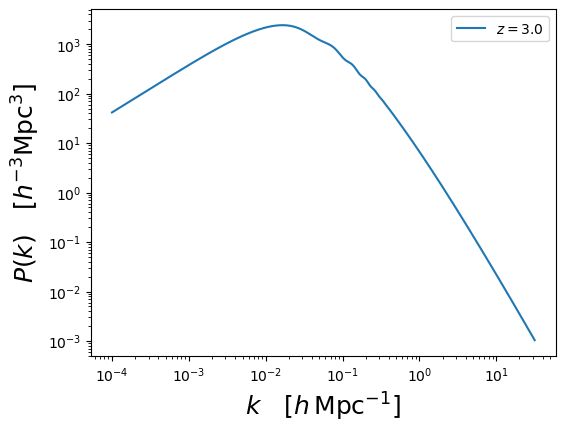

In [6]:
fig,ax = plt.subplots(1,1,figsize=(6,4.5))
ax.plot(kk,pk,label="$z={:.1f}$".format(zz))
ax.legend()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$k\quad [h\,{\rm Mpc}^{-1}]$',fontsize=18)
ax.set_ylabel(r'$P(k)\quad [h^{-3}{\rm Mpc}^3]$',fontsize=18)

### The luminosity function and bias of LBGs

These are just fits taken from the literature.

In [7]:
# Schechter function fits from the literature.  The phi* definition
# is in terms of L, i.e. there is a 0.4ln(10) going to magnitudes.
# phi* is in units of Mpc^{-3} and converted to Mpc/h below.
LFlist = []
LFlist.append({'zrange':'1.9<z<2.7','zfid':2.0,\
               'phis':3.31e-3,'mstar':-20.60,'alpha':-1.60,\
               'ref':'R08:Tab7'})
LFlist.append({'zrange':'3.0<z<3.6','zfid':3.0,\
               'phis':10**(-2.73),'mstar':-20.86,'alpha':-1.78,\
               'ref':'M17'})
LFlist.append({'zrange':'3.25<z<4.2','zfid':3.8,\
               'phis':3.04e-3,'mstar':-20.63,'alpha':-1.57,\
               'ref':'O17:Tab7'})
LFlist.append({'zrange':'4.4<z<5.2','zfid':4.9,\
               'phis':1.06e-3,'mstar':-20.96,'alpha':-1.60,\
               'ref':'O17:Tab7'})

In [8]:
def nbar_fit(mag,zz):
    """Computes nbar, in [Mpc/h]^{-3}, given apparent magnitude
    for dropout galaxies.  Assumes the 'color' K-correction is zero."""
    delz= np.array([np.abs(zz-lf['zfid']) for lf in LFlist])
    lf  = LFlist[np.argmin(delz)]
    #
    hub = cosmo.h()
    dL  = cosmo.luminosity_distance(zz)
    dmod= 25. + 5.*np.log10(dL)
    kcorr= 2.5*np.log10(1.0+zz)     # Color term is ~0.
    phis,mstar,alpha = lf['phis']/hub**3,lf['mstar'],lf['alpha']
    #
    Mabs = mag - dmod + kcorr
    L    = 10.0**(-0.4*(Mabs-mstar))
    mm   = np.linspace(mstar-10.,Mabs,1000)
    ll   = 10.0**(-0.4*(mm-mstar))
    lf   = phis * ll**(alpha+1) * np.exp(-ll)
    nbar = np.trapz(lf,mm)
    return(nbar)

In [9]:
def bias_fit(mm,zz):
    """The large-scale bias from Eq. (2.7) of W&W
      https://arxiv.org/pdf/1904.13378.pdf"""
    Am = -0.98*(mm-25.)+0.11
    Bm =  0.12*(mm-25.)+0.17
    bb =  Am*(1+zz)+Bm*(1+zz)**2
    return(bb)
    #

In [10]:
# Just do a sanity check.
mag = 24.50
chi = cosmo.comoving_distance(zz) * cosmo.h()
#
print("Mag  ={:5.1f} ".format(mag))
print("z    ={:5.1f} ".format(zz))
print("nbar ={:10.2e}".format(nbar_fit(mag,zz))+r' [Mpc/h]^3')
print("bias ={:6.2f} ".format(bias_fit(mag,zz)))
print("chi  ={:5.0f}Mpc/h".format(chi))

Mag  = 24.5 
z    =  3.0 
nbar =  6.62e-04 [Mpc/h]^3
bias =  4.16 
chi  = 4383Mpc/h


In [11]:
# Later it will be useful to have a list of number densities
# that we'll try to match to.
print("# {:>4s} {:>12s} {:>10s}".format("mag","nbar","ntar"))
for rmag in [24.0,24.5,25.0]:
    nbar = nbar_fit(rmag,zz)
    ntar = nbar * Lbox**3
    print("{:6.2f} {:12.4e} {:10.2e}".format(rmag,nbar,ntar))

#  mag         nbar       ntar
 24.00   1.7302e-04   1.38e+06
 24.50   6.6186e-04   5.29e+06
 25.00   1.8754e-03   1.50e+07


### Velocileptors

Set up the velocileptors instance and just compute an example with semi-randomly chosen parameters to exercise the code.

In [12]:
lpt = LPT_RSD(kk,pl,kIR=0.3)

Text(0, 0.5, '$i^\\ell\\ s^2\\xi_\\ell(s)\\quad [h^{-2}{\\rm Mpc}^2]$')

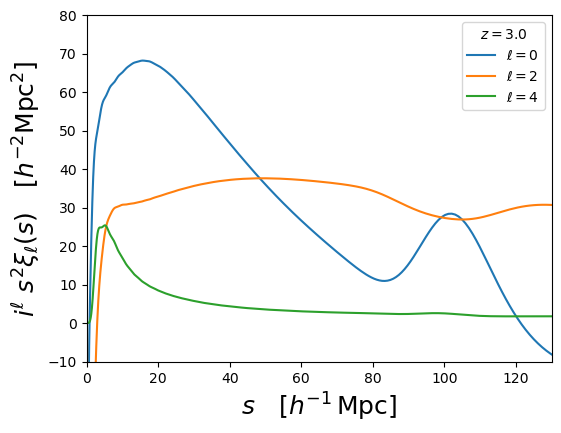

In [13]:
# b1,b2,bs, b3: linear, quadratic & cubic bias parameters
# alpha0,alpha2,alpha4,alpha6: counterterms
# sn0,sn2,sn4: stochastic contributions to P(k) and sigma^2.
#
biases = [2.96,6.2,-1.3,0]
cterms = [-79.,53.,0,0]
stoch  = [0,0,0]
pars   = biases + cterms + stoch
#
lpt.make_pltable(ff,apar=1,aperp=1)
kl,p0,p2,p4 = lpt.combine_bias_terms_pkell(pars)
xi0,xi2,xi4 = lpt.make_xiell_fixedbias(ff,pars,apar=1,aperp=1,kmax=3.0,nk=150)
#
fig,ax = plt.subplots(1,1,figsize=(6,4.5))
ax.plot(xi0[0], xi0[0]**2*xi0[1],label=r'$\ell = 0$')
ax.plot(xi2[0],-xi2[0]**2*xi2[1],label=r'$\ell = 2$')
ax.plot(xi4[0], xi4[0]**2*xi4[1],label=r'$\ell = 4$')
ax.legend(title='$z={:.1f}$'.format(zz))
ax.set_xlim(0.0,130.0)
ax.set_ylim(-10.,80.0)
ax.set_xscale('linear')
ax.set_yscale('linear')
ax.set_xlabel(r'$s\quad [h^{-1}\,{\rm Mpc}]$',fontsize=18)
ax.set_ylabel(r'$i^\ell\ s^2\xi_\ell(s)\quad [h^{-2}{\rm Mpc}^2]$',fontsize=18)

In [14]:
def xi_lpt(klin,plin):
    """Runs velocileptors to get the real-space (matter) correlation."""
    # No bias, no counterterms and no stochastic terms.
    biases = [0.0,0.0,0.0,0.0]
    cterms = [0.0,0.0,0.0,0.0]
    stoch  = [0.0,0.0,0.0]
    pars   = biases + cterms + stoch
    # By setting f=0 we "turn off" velocities:
    lpt = LPT_RSD(klin,plin,kIR=0.3)
    lpt.make_pltable(f=0,apar=1,aperp=1,kmin=1e-3,kmax=1.0,nk=100,nmax=4)
    xi0,xi2,xi4 = lpt.combine_bias_terms_xiell(pars)
    return(xi0)
    #

In [15]:
ximm = xi_lpt(kk,pl)

In [16]:
def extend_xir(xi,Nuse=-4):
    """Uses an analytic correlation function to extend the range of xi(r).
    This assumes constant bias for simplicity.  Returns a spline and bias."""
    xv = Spline(ximm[0],ximm[1],ext='zeros')(xi[Nuse:,0])
    b2 = np.mean(xi[Nuse:,1]/xv)
    bb = np.sqrt(b2)
    # Set up a spline.
    w1 = np.nonzero( xi[:,1]>0 )[0]
    w2 = np.nonzero( (ximm[0]>1.5*xi[-1,0])&(ximm[0]<=100) )[0]
    xv = np.append(xi[w1,0],ximm[0][w2])
    yv = np.append(xi[w1,1],b2*ximm[1][w2])
    ss = Spline(xv,yv,ext='zeros')
    return( (ss,bb) )

### Large-scale bias

We now have enough information to "extend" the N-body xi(r) and compute a bias estimate.  For now let's store this information in the LBG dictionary, to be used later.

In [17]:
xi      = np.zeros( (len(lbg['R']),2) )
xi[:,0] = lbg['R']
for i in range(len(lbg['mocks'])):
    samp    = lbg['mocks'][i]
    xi[:,1] = samp['xi0']
    xext,bb = extend_xir(xi)
    lbg['mocks'][i]['bias'] = bb
    lbg['mocks'][i]['xir' ] = xext

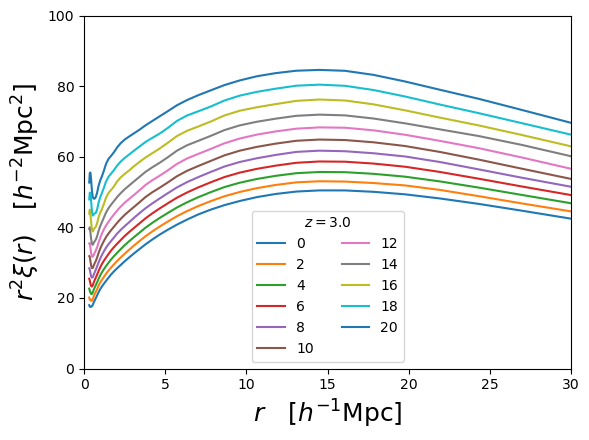

In [18]:
# Plot the correlation functions.  These can be
# slightly "noisy" at low r, but that shouldn't
# concern us for our principle use, which is to
# compute w(theta).
fig,ax = plt.subplots(1,1,figsize=(6,4.5))
icol,rr = 0,np.logspace(-0.5,1.7,50)
for i in range(0,len(lbg['mocks']),2):
    samp = lbg['mocks'][i]
    ax.plot(rr,rr**2*samp['xir'](rr),ls='-',color='C'+str(icol),\
            mfc='None',label=str(i))
    icol = (icol+1)%10
#
ax.legend(title='$z={:.1f}$'.format(zz),ncol=2)
ax.set_xlim(0.0,30.0)
ax.set_ylim(0.0,100.)
ax.set_xscale('linear')
ax.set_yscale('linear')
ax.set_xlabel(r'$r\quad[h^{-1}{\rm Mpc}]$',fontsize=18)
ax.set_ylabel(r'$r^2\xi(r)\quad[h^{-2}{\rm Mpc}^2]$',fontsize=18)
plt.tight_layout()

### Statistics of the HOD models

We can now look at the large-scale bias and number density of the HODs compared to our targets.

In [19]:
# How much would we need to downsample each HOD model to
# match the nbar for this magnitude limit, and how does
# the large-scale bias compare?
ntar = nbar_fit(mag,zz) * Lbox**3
print("# {:35s} {:>6s} {:>6s} {:>10s} {:>6s}".format('HOD','fsat','bias','nbar','fsamp'))
for i,samp in enumerate(lbg['mocks']):
    bias   = samp['bias']
    hodstr = "{:2d}".format(i)
    for p in samp['hod']: hodstr += " {:6.2f}".format(p)
    stats  = " {:6.2f} {:6.2f}".format(samp['fsat'],bias)
    stats += " {:10.2e} {:6.2f}".format(samp['nobj']/Lbox**3,ntar/samp['nobj'])
    print(hodstr+stats)

# HOD                                   fsat   bias       nbar  fsamp
 0  12.00  13.40   0.30   1.00   0.75   0.04   3.65   1.18e-03   0.56
 1  12.00  13.40   0.40   1.00   0.75   0.02   3.30   1.68e-03   0.39
 2  12.05  13.45   0.30   1.00   0.75   0.03   3.74   9.84e-04   0.67
 3  12.05  13.45   0.40   1.00   0.75   0.02   3.38   1.42e-03   0.47
 4  12.10  13.50   0.30   1.00   0.75   0.03   3.83   8.18e-04   0.81
 5  12.10  13.50   0.40   1.00   0.75   0.02   3.45   1.20e-03   0.55
 6  12.15  13.55   0.30   1.00   0.75   0.03   3.92   6.79e-04   0.97
 7  12.15  13.55   0.40   1.00   0.75   0.02   3.52   1.01e-03   0.66
 8  12.20  13.60   0.30   1.00   0.75   0.03   4.02   5.61e-04   1.18
 9  12.20  13.60   0.40   1.00   0.75   0.02   3.59   8.48e-04   0.78
10  12.25  13.65   0.30   1.00   0.75   0.03   4.11   4.63e-04   1.43
11  12.25  13.65   0.40   1.00   0.75   0.02   3.67   7.10e-04   0.93
12  12.30  13.70   0.30   1.00   0.75   0.03   4.21   3.80e-04   1.74
13  12.30  13.70   0

### Angular correlation function

Now we import some code to do angular correlation functions, and the w(theta) data with dN/dz.

In [20]:
from wtheta_xi import LCDM,read_pchi,w_theta
#
pchi = read_pchi( "H09_udrop_dndz.txt",LCDM(cosmo.Omega_m()))
wdat = np.loadtxt("H09_udrop_r245.txt")

### Fit to N-body

Now we can try to fit to our N-body results.  For now we ignore variance reduction or other tricks.

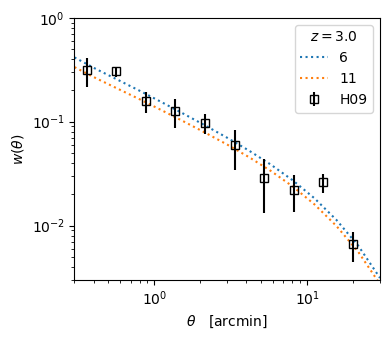

In [21]:
# Begin by looking at the w(theta) results.
fig,ax = plt.subplots(1,1,figsize=(4,3.5))
# First plot the N-body w(theta).  We are only interested in
# those models "close" to the data.
btar = bias_fit(mag,zz)
ntar = nbar_fit(mag,zz) * Lbox**3
icol = 0
thta = np.logspace(np.log10(0.3),np.log10(30.0),15) # arcmin.
wth  = np.empty_like(thta)
for i,samp in enumerate(lbg['mocks']):
    if (samp['nobj']>0.90*ntar)&(samp['nobj']<1.10*ntar)&\
       (samp['bias']>0.75*btar)*(samp['bias']<1.25*btar):
        for j in range(thta.size):
            wth[j] = w_theta(thta[j]/60*np.pi/180.,pchi,samp['xir'])
        ls = '--' if samp['hod'][0]<11.9 else ':'
        ax.plot(thta,wth,ls=ls,color='C'+str(icol),\
            mfc='None',label=str(i))
        icol = (icol+1)%10
# Now plot the data.
ax.errorbar(wdat[:,0],wdat[:,1],yerr=wdat[:,2],fmt='s',\
            mfc='None',color='k',label='H09')
#
ax.legend(title='$z={:.1f}$'.format(zz))
ax.set_xlim(0.30,30.0)
ax.set_ylim(3e-3, 1.0)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\theta\quad [{\rm arcmin}]$')
ax.set_ylabel(r'$w(\theta)$')
plt.tight_layout()
plt.savefig('abacus_lbg_r245_wth.png')
plt.savefig('abacus_lbg_r245_wth.pdf')

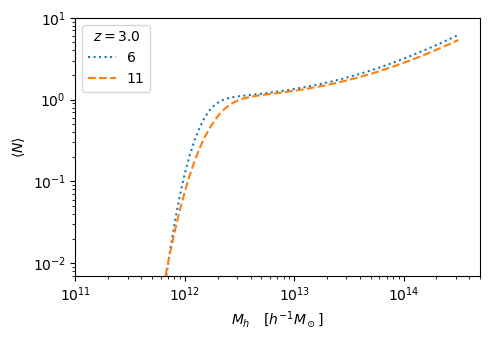

In [22]:
# and we can look at their HODs.
fig,ax = plt.subplots(1,1,figsize=(5,3.5))
# We are only interested in those models "close" to the data.
icol = 0
for i,samp in enumerate(lbg['mocks']):
    if (samp['nobj']>0.90*ntar)&(samp['nobj']<1.10*ntar)&\
       (samp['bias']>0.75*btar)*(samp['bias']<1.25*btar):
        mhalo = np.logspace(10.0,14.5,100)
        mcut  = 10.**samp['hod'][0]
        m1    = 10.**samp['hod'][1]
        sigm  = samp['hod'][2]
        kapp  = samp['hod'][3]
        alph  = samp['hod'][4]
        ncen  = 0.5*erfc(np.log(mcut/mhalo)/np.sqrt(2.0)/sigm)
        nsat  = (mhalo-kapp*mcut).clip(0,1e30)
        nsat  = ( (nsat/m1)**alph ) * ncen
        ls    = ':' if i<10 else '--'
        ax.plot(mhalo,ncen+nsat,ls=ls,color='C'+str(icol),label=str(i))
        icol = (icol+1)%10
# Put on a lower halo mass, assuming 35 particle minimum.
#ax.axvline(35*lbg['ParticleMassHMsun'],ls=':',color='k')
#
ax.legend(title='$z={:.1f}$'.format(zz))
ax.set_xlim(1e11,5e14)
ax.set_ylim(7e-3, 10.)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$M_h\quad [h^{-1}M_\odot]$')
ax.set_ylabel(r'$\langle N\rangle$')
plt.tight_layout()
plt.savefig('abacus_lbg_r245_hod.png')

### Redshift-space clustering

Now we can take a look at the redshift-space clustering for the "best fitting" model.

In [23]:
lbg = json.load(open("lbg_clustering_c000_ph000_s.json","r"))
#
print("# {:35s} {:>6s} {:>10s}".format('HOD','fsat','nbar'))
for i,samp in enumerate(lbg['mocks']):
    hodstr = "{:2d}".format(i)
    for p in samp['hod']: hodstr += " {:6.2f}".format(p)
    hodstr += " {:6.2f}".format(samp['fsat'])
    hodstr += " {:10.2e}".format(samp['nobj']/Lbox**3)
    print(hodstr)

# HOD                                   fsat       nbar
 0  12.15  13.55   0.30   1.00   0.75   0.03   6.79e-04
 1  12.50  13.90   0.30   1.00   0.75   0.02   1.67e-04
 2  11.75  13.15   0.30   1.00   0.75   0.04   2.77e-03


In [24]:
# Select the model from the list that we will
# study further.
ihod   = 0
samp   = lbg['mocks'][ihod]

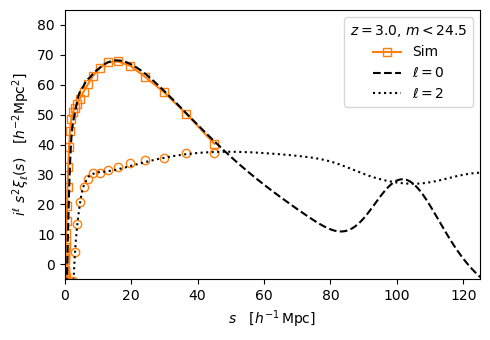

In [25]:
fig,ax = plt.subplots(1,1,figsize=(5,3.5))
# First plot the N-body xi_ell.
ss   = np.array(lbg['R'])
s2   = ss**2
icol = 1
#
ax.plot(ss, s2*samp['xi0'],'s-',color='C'+str(icol),mfc='None',label="Sim")
ax.plot(ss,-s2*samp['xi2'],'o' ,color='C'+str(icol),mfc='None')
#
ax.plot(xi0[0], xi0[0]**2*xi0[1],'k--',label=r'$\ell = 0$')
ax.plot(xi2[0],-xi2[0]**2*xi2[1],'k:' ,label=r'$\ell = 2$')
ax.legend(title='$z={:.1f}$, $m<{:.1f}$'.format(zz,24.5))
ax.set_xlim( 0,125.0)
ax.set_ylim(-5, 85.0)
ax.set_xscale('linear')
ax.set_yscale('linear')
ax.set_xlabel(r'$s\quad [h^{-1}\,{\rm Mpc}]$')
ax.set_ylabel(r'$i^\ell\ s^2\xi_\ell(s)\quad [h^{-2}{\rm Mpc}^2]$')
plt.tight_layout()
plt.savefig('abacus_lbg_r245_xil.png')

Setting sn0= 1514.9598903189833 , sn2= -238.64691535757348
nbar= 0.00067890875  so Poisson= 1472.9519983355642


Text(0, 0.5, '$P_\\ell(k)\\quad [h^{-3}{\\rm Mpc}^3]$')

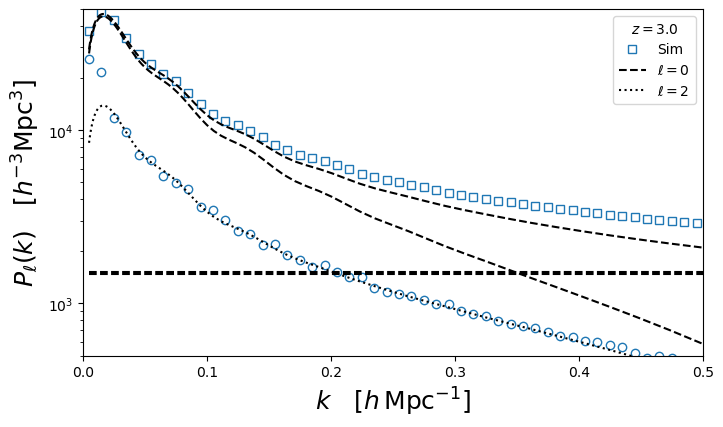

In [26]:
# Now we can also look at the power spectra predicted by
# this model.  We may want to adjust the stochastic terms,
# for now let us set them to an unweighted difference
# between the data and the theory without such terms.
kk,pk0,pk2 = np.array(lbg['k']),np.array(samp['pk0']),np.array(samp['pk2'])
ii = np.nonzero( (kk>0.20)&(kk<0.40) )[0]
sn0 = np.mean(pk0[ii]-np.interp(kk[ii],kl,p0))
sn2 = np.mean(pk2[ii]-np.interp(kk[ii],kl,p2))
print("Setting sn0=",sn0,", sn2=",sn2)
#
nbar = samp['nobj']/Lbox**3
print("nbar=",nbar," so Poisson=",1.0/nbar)
#
# b1,b2,bs, b3: linear, quadratic & cubic bias parameters
# alpha0,alpha2,alpha4,alpha6: counterterms
# sn0,sn2, sn4: stochastic contributions to P(k) and sigma^2.
stoch  = [sn0,sn2,0]
pars   = biases + cterms + stoch
#
lpt.make_pltable(ff,apar=1,aperp=1,kmin=5e-3,kmax=1.0,nk=100,nmax=4)
kl,p0,p2,p4 = lpt.combine_bias_terms_pkell(pars)
#
fig,ax = plt.subplots(1,1,figsize=(8,4.5))
#
kk = np.array(lbg['k'])
ax.plot(kk,1*pk0,'s',color='C0',mfc='None',label="Sim")
ax.plot(kk,1*pk2,'o',color='C0',mfc='None')
#
ax.plot(kl,1*p0,'k--',label=r'$\ell = 0$')
ax.plot(kl,1*p2,'k:' ,label=r'$\ell = 2$')
ax.plot(kl,p0  -sn0,'k--')
ax.plot(kl,0*kl+sn0,'k--')
ax.plot(kl,0*kl+1/nbar,'k--')
#
ax.legend(title='$z={:.1f}$'.format(zz))
ax.set_xlim(0.0,0.50)
ax.set_ylim(500.,5e4)
ax.set_xscale('linear')
ax.set_yscale('log')
ax.set_xlabel(r'$k\quad [h\,{\rm Mpc}^{-1}]$',fontsize=18)
ax.set_ylabel(r'$P_\ell(k)\quad [h^{-3}{\rm Mpc}^3]$',fontsize=18)

### Fitting

Now let's fit the model more seriously to an average of the data from multiple simulations.

In [27]:
class GoodnessFit:
    def __init__(self,pka,klin,plin,ff,kmin=0.05,kmax=0.40):
        """Takes care of setting up what we need."""
        # Set up the LPT model.
        self.klin= klin.copy()
        self.plin= plin.copy()
        self.ff  = ff
        self.lpt = LPT_RSD(klin,plin,ff,kIR=0.3)
        self.lpt.make_pltable(ff,apar=1,aperp=1,kmin=5e-3,kmax=1.0,nk=100,nmax=4)
        # Copy the data array
        self.pka  = pka.copy()
        # and make up an error vector.
        self.kmin = kmin
        self.kmax = kmax
        self.err0 = 0.1 * self.pka[:,1]
        self.err2 = 0.1 * self.pka[:,1] # Std[P2]~P0.
        if kmin>np.min(self.pka[:,0]):
            self.err0[self.pka[:,0]<kmin] = 1e10  # Remove low k.
            self.err2[self.pka[:,0]<kmin] = 1e10  # Remove low k.
        if kmax<np.max(self.pka[:,0]):
            self.err0[self.pka[:,0]>kmax] = 1e10  # Remove high k.
            self.err2[self.pka[:,0]>kmax] = 1e10  # Remove high k.
        #
    def __call__(self,params):
        """Returns chi^2."""
        # Unpack the parameters and compute the theory using the
        # pregenerated LPT tables.
        b1,b2,bs,b3 = params[0],params[1],params[2],0.0
        a0,a2,a4,a6 = params[3],params[4],0.0,0.0
        sn0,sn2,sn4 = params[5],params[6],0.0
        pars = [b1,b2,bs,b3] + [a0,a2,a4,a6] + [sn0,sn2,sn4]
        kl,p0,p2,p4 = self.lpt.combine_bias_terms_pkell(pars)
        # Now interpolate onto the data.
        self.thy0 = Spline(kl,p0)(self.pka[:,0])
        self.thy2 = Spline(kl,p2)(self.pka[:,0])
        # Neglect any covariances, we're assuming that we have
        # an almost noisely "data vector" so we just want to get
        # close to the data not really do a fit.
        chi2 = np.sum( ((self.pka[:,1]-self.thy0)/self.err0)**2 ) +\
               np.sum( ((self.pka[:,2]-self.thy2)/self.err2)**2 )
        #
        return(chi2)

In [28]:
def read_zcv_files(ihod,Nfiles=3):
    """Averages P_ell(k) from multiple JSON files."""
    pka = None
    for i in range(Nfiles):
        fn  = "lbg_m{:03d}_c000_ph{:03d}_s_zcv.json".format(ihod,i)
        zcv = json.load(open(fn,"r"))
        if pka is None:
            pka = np.zeros( (len(zcv['k']),4) )
        pka[:,0] += zcv['k']
        pka[:,1] += zcv['pk0']
        pka[:,2] += zcv['pk2']
        pka[:,3] += zcv['pk4']
    pka /= Nfiles
    return(pka)

In [29]:
# Remake the linear theory power spectrum, just to start
# from a clean slate.
zz = lbg['Redshift']
ff = cosmo.scale_independent_growth_factor_f(zz)
# Work out the linear theory scaling from z=1 to desired z.
zspecial = 1.0
scaleto  = cosmo.scale_independent_growth_factor(zz)
scaleto /= cosmo.scale_independent_growth_factor(zspecial)
scaleto *= scaleto
#
hub= cosmo.h()                # To convert to "conventional" Mpc/h units.
kl = np.logspace(-4.0,1.5,1000)
pl = np.array( [cosmo.pk_cb_lin(k*hub,zspecial)*hub**3 for k in kl] ) * scaleto

In [30]:
from scipy.optimize import minimize
#
pka = read_zcv_files(0,1)
#
kmin = 0.05
kmax = 0.45
chi2 = GoodnessFit(pka,kl,pl,ff,kmin,kmax)
par0 = [2.95,6.0,-1.4,-77,50,2200,0]
#
res  = minimize(chi2,par0,method='Nelder-Mead',options={'maxfev':5000,'maxiter':5000})
print(res)
# Rerun at the best fit, which also saves
# the predictions inside the class.
chi2min = chi2(res.x)
bE      = res.x[0] + 1.0

 final_simplex: (array([[ 3.03187716e+00,  5.78237212e+00, -5.91905853e+00,
        -3.47754810e+01,  1.33218751e+01,  1.76943683e+03,
         5.49887948e-04],
       [ 3.03187716e+00,  5.78237182e+00, -5.91905902e+00,
        -3.47754844e+01,  1.33218785e+01,  1.76943689e+03,
         5.49886257e-04],
       [ 3.03187716e+00,  5.78237187e+00, -5.91905909e+00,
        -3.47754816e+01,  1.33218759e+01,  1.76943685e+03,
         5.49886758e-04],
       [ 3.03187716e+00,  5.78237209e+00, -5.91905883e+00,
        -3.47754758e+01,  1.33218707e+01,  1.76943678e+03,
         5.49888510e-04],
       [ 3.03187716e+00,  5.78237191e+00, -5.91905891e+00,
        -3.47754852e+01,  1.33218790e+01,  1.76943689e+03,
         5.49886303e-04],
       [ 3.03187716e+00,  5.78237197e+00, -5.91905873e+00,
        -3.47754863e+01,  1.33218799e+01,  1.76943690e+03,
         5.49886401e-04],
       [ 3.03187716e+00,  5.78237199e+00, -5.91905838e+00,
        -3.47754856e+01,  1.33218794e+01,  1.76943691e+03,
 

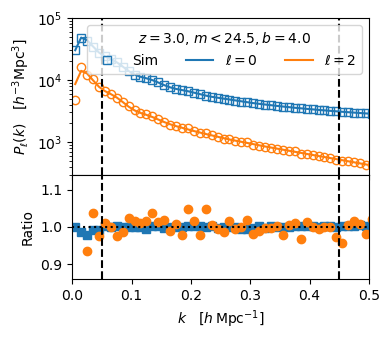

In [31]:
fig,ax = plt.subplots(2,1,figsize=(4,3.5),sharex=True,\
                      gridspec_kw={'hspace':0,'height_ratios':[3,2]})
#
pka,thy0,thy2 = chi2.pka,chi2.thy0,chi2.thy2
ax[0].plot(pka[:,0],pka[:,1],'s',color='C0',mfc='None',label="Sim")
ax[0].plot(pka[:,0],pka[:,2],'o',color='C1',mfc='None')
#
ax[0].plot(pka[:,0],thy0,'-',color='C0',label=r'$\ell=0$')
ax[0].plot(pka[:,0],thy2,'-',color='C1',label=r'$\ell=2$')
#
ax[1].plot(pka[:,0],pka[:,1]/thy0,'s',color='C0')
ax[1].plot(pka[:,0],pka[:,2]/thy2,'o',color='C1')
#
for av in ax:
    av.axvline(kmin,ls='--',color='k')
    av.axvline(kmax,ls='--',color='k')
ax[1].axhline(1.0,ls=':',color='k')
#
ax[0].legend(title='$z={:.1f}$, $m<{:.1f}, b={:.1f}$'.format(zz,24.5,bE),ncol=3)
ax[0].set_xlim(0.0,0.50)
ax[1].set_xlim(0.0,0.50)
ax[0].set_ylim(300.,1e5)
ax[1].set_ylim(0.86,1.14)
ax[0].set_xscale('linear')
ax[0].set_yscale('log')
ax[1].set_xlabel(r'$k\quad [h\,{\rm Mpc}^{-1}]$')
ax[0].set_ylabel(r'$P_\ell(k)\quad [h^{-3}{\rm Mpc}^3]$')
ax[1].set_ylabel(r'Ratio')
#
plt.tight_layout()
plt.savefig('abacus_lbg_r245_pkl.png')
plt.savefig('abacus_lbg_r245_pkl.pdf')

In [32]:
# It's also useful to save the best fit theory model.
with open("abacus_lbg_r245_mod.txt","w") as fout:
    fout.write("# Best-fitting LPT model for m<24.5 LBGs.\n")
    fout.write("# Eulerian bias {:f}\n".format(bE))
    fout.write("# {:>10s} {:>12s} {:>12s}\n".format("k[h/Mpc]","P0","P2"))
    for i in range(pka.shape[0]):
        fout.write("{:>12.4e} {:>12.4e} {:>12.4e}\n".format(pka[i,0],thy0[i],thy2[i]))
#

### Scale-dependent bias

Now we can see how large a contribution to $P(k)$ the scale-dependent bias terms are making.

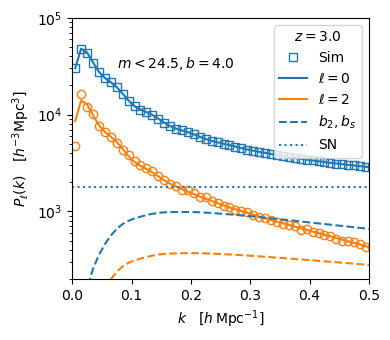

In [33]:
fig,ax = plt.subplots(1,1,figsize=(4,3.5))
#
pka,thy0,thy2 = chi2.pka,chi2.thy0,chi2.thy2
ax.plot(pka[:,0],pka[:,1],'s',color='C0',mfc='None',label="Sim")
ax.plot(pka[:,0],pka[:,2],'o',color='C1',mfc='None')
ax.plot(pka[:,0],thy0,'-',color='C0',label=r'$\ell=0$')
ax.plot(pka[:,0],thy2,'-',color='C1',label=r'$\ell=2$')
#
pars = res.x.copy()
pars[1]=pars[2]=0
chi2min = chi2(pars)
dthy0,dthy2 = thy0 - chi2.thy0,thy2 - chi2.thy2
ax.plot(pka[:,0],dthy0,'--',color='C0',label=r'$b_2,b_s$')
ax.plot(pka[:,0],dthy2,'--',color='C1')
ax.axhline(res.x[-2],ls=':',color='C0',label=r'SN')
#
ax.text(0.175,3e4,r'$m<24.5, b={:.1f}$'.format(bE),ha='center')
ax.legend(title='$z={:.1f}$'.format(zz))
ax.set_xlim(0.0,0.50)
ax.set_ylim(200.,1e5)
ax.set_xscale('linear')
ax.set_yscale('log')
ax.set_xlabel(r'$k\quad [h\,{\rm Mpc}^{-1}]$')
ax.set_ylabel(r'$P_\ell(k)\quad [h^{-3}{\rm Mpc}^3]$')
#
plt.tight_layout()
plt.savefig('abacus_lbg_r245_bns.png')
plt.savefig('abacus_lbg_r245_bns.pdf')

### Bright sample

And for completeness, let's look at what happens for the brighter sample.

In [34]:
kmin = 0.05
kmax = 0.45
#
pka = read_zcv_files(1,2)
#
chi2 = GoodnessFit(pka,kl,pl,ff,kmin,kmax)
par0 = [3.7,10.,-1.5,-100,150,8000,0]
#
res  = minimize(chi2,par0,method='Nelder-Mead',options={'maxfev':5000,'maxiter':5000})
print(res)
# Rerun at the best fit, which also saves
# the predictions inside the class.
chi2min = chi2(res.x)
bE      = res.x[0] + 1.0

 final_simplex: (array([[ 3.84848212e+00,  9.92529120e+00, -9.50481632e+00,
        -8.61392809e+01,  4.35697858e+01,  6.72774496e+03,
        -7.21504755e-02],
       [ 3.84848212e+00,  9.92529118e+00, -9.50481633e+00,
        -8.61392817e+01,  4.35697866e+01,  6.72774498e+03,
        -7.21504756e-02],
       [ 3.84848212e+00,  9.92529121e+00, -9.50481638e+00,
        -8.61392772e+01,  4.35697826e+01,  6.72774492e+03,
        -7.21504761e-02],
       [ 3.84848212e+00,  9.92529123e+00, -9.50481630e+00,
        -8.61392798e+01,  4.35697848e+01,  6.72774495e+03,
        -7.21504754e-02],
       [ 3.84848212e+00,  9.92529127e+00, -9.50481618e+00,
        -8.61392773e+01,  4.35697826e+01,  6.72774492e+03,
        -7.21504743e-02],
       [ 3.84848212e+00,  9.92529119e+00, -9.50481636e+00,
        -8.61392805e+01,  4.35697855e+01,  6.72774496e+03,
        -7.21504759e-02],
       [ 3.84848212e+00,  9.92529118e+00, -9.50481627e+00,
        -8.61392832e+01,  4.35697878e+01,  6.72774499e+03,
 

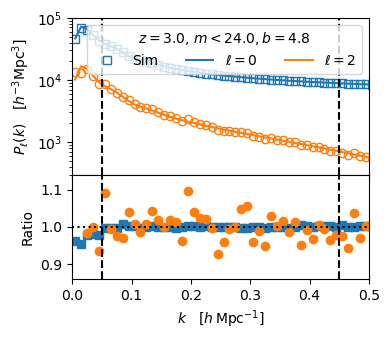

In [35]:
fig,ax = plt.subplots(2,1,figsize=(4,3.5),sharex=True,\
                      gridspec_kw={'hspace':0,'height_ratios':[3,2]})
#
pka,thy0,thy2 = chi2.pka,chi2.thy0,chi2.thy2
ax[0].plot(pka[:,0],pka[:,1],'s',color='C0',mfc='None',label="Sim")
ax[0].plot(pka[:,0],pka[:,2],'o',color='C1',mfc='None')
#
ax[0].plot(pka[:,0],thy0,'-',color='C0',label=r'$\ell=0$')
ax[0].plot(pka[:,0],thy2,'-',color='C1',label=r'$\ell=2$')
#
ax[1].plot(pka[:,0],pka[:,1]/thy0,'s',color='C0')
ax[1].plot(pka[:,0],pka[:,2]/thy2,'o',color='C1')
#
for av in ax:
    av.axvline(kmin,ls='--',color='k')
    av.axvline(kmax,ls='--',color='k')
ax[1].axhline(1.0,ls=':',color='k')
#
ax[0].legend(title='$z={:.1f}$, $m<{:.1f}, b={:.1f}$'.format(zz,24.0,bE),ncol=3)
ax[0].set_xlim(0.0,0.50)
ax[1].set_xlim(0.0,0.50)
ax[0].set_ylim(300.,1e5)
ax[1].set_ylim(0.86,1.14)
ax[0].set_xscale('linear')
ax[0].set_yscale('log')
ax[1].set_xlabel(r'$k\quad [h\,{\rm Mpc}^{-1}]$')
ax[0].set_ylabel(r'$P_\ell(k)\quad [h^{-3}{\rm Mpc}^3]$')
ax[1].set_ylabel(r'Ratio')
#
plt.tight_layout()
plt.savefig('abacus_lbg_r240_pkl.png')

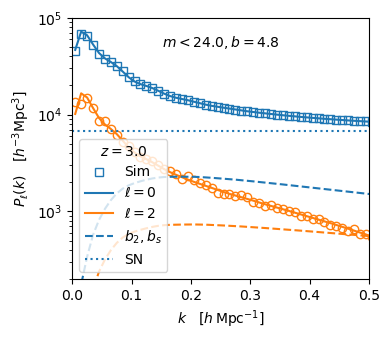

In [36]:
fig,ax = plt.subplots(1,1,figsize=(4,3.5))
#
pka,thy0,thy2 = chi2.pka,chi2.thy0,chi2.thy2
ax.plot(pka[:,0],pka[:,1],'s',color='C0',mfc='None',label="Sim")
ax.plot(pka[:,0],pka[:,2],'o',color='C1',mfc='None')
ax.plot(pka[:,0],thy0,'-',color='C0',label=r'$\ell=0$')
ax.plot(pka[:,0],thy2,'-',color='C1',label=r'$\ell=2$')
#
pars = res.x.copy()
pars[1]=pars[2]=0
chi2min = chi2(pars)
dthy0,dthy2 = thy0 - chi2.thy0,thy2 - chi2.thy2
ax.plot(pka[:,0],dthy0,'--',color='C0',label=r'$b_2,b_s$')
ax.plot(pka[:,0],dthy2,'--',color='C1')
ax.axhline(res.x[-2],ls=':',color='C0',label=r'SN')
#
ax.text(0.25,5e4,r'$m<24.0, b={:.1f}$'.format(bE),ha='center')
ax.legend(title='$z={:.1f}$'.format(zz),loc=3)
ax.set_xlim(0.0,0.50)
ax.set_ylim(200.,1e5)
ax.set_xscale('linear')
ax.set_yscale('log')
ax.set_xlabel(r'$k\quad [h\,{\rm Mpc}^{-1}]$')
ax.set_ylabel(r'$P_\ell(k)\quad [h^{-3}{\rm Mpc}^3]$')
#
plt.tight_layout()
plt.savefig('abacus_lbg_r240_bns.png')
plt.savefig('abacus_lbg_r240_bns.pdf')

In [37]:
# It's also useful to save the best fit theory model.
with open("abacus_lbg_r240_mod.txt","w") as fout:
    fout.write("# Best-fitting LPT model for m<24.0 LBGs.\n")
    fout.write("# Eulerian bias {:f}\n".format(bE))
    fout.write("# {:>10s} {:>12s} {:>12s}\n".format("k[h/Mpc]","P0","P2"))
    for i in range(pka.shape[0]):
        fout.write("{:>12.4e} {:>12.4e} {:>12.4e}\n".format(pka[i,0],thy0[i],thy2[i]))
#

# Done